In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [ ]:
root = r"C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images"

In [ ]:
#def get_model(num_classes):
    
    # load an object detection model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = 2
    
    # replace the pre-trained head with a new on
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    
#return model



### Faster-RCNN with fc layers

In [ ]:
print(model)

In [ ]:
model.roi_heads.box_head = torch.nn.Sequential(torch.nn.Flatten(start_dim=1), model.roi_heads.box_head.fc6) 

mod = torch.nn.Sequential(*list(model.children())[:-1]) 

### Faster-RCNN without fc layers

In [ ]:
print(model)

### Once the last fc convoluted layer has been removed, we will extract the weights from the model parameters.

In [ ]:
params = list(model.parameters()) 

#print(params) 

In [ ]:
weight = np.squeeze(params[-1].data.numpy()) 

print(weight) 

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [ ]:
#root = r"C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images" 

#imgs = list(sorted(os.listdir(os.path.join(root, "mixed set")))) 

#print(imgs)
                              

In [ ]:
import torchvision.transforms as t2
class SmokeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "mixed set"))) 
        self.t1 = t2.Compose([t2.Resize((720,1280))])
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "mixed set", self.imgs[idx]) 
        img = Image.open(img_path).convert("RGB")
        img = self.t1(img) 

    def __len__(self):
        return len(self.imgs)

In [ ]:
import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    # during training, randomly flip the training images
    # and ground-truth for data augmentation
    #transforms.append(T.RandomHorizontalFlip(0.5))
    #transforms.append(T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)))
    return T.Compose(transforms)

In [ ]:
root = r"C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images" 

In [ ]:
dataset = SmokeDataset(root= r"C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images" , transforms=get_transform(train=True))

In [ ]:
dataset_test = SmokeDataset(root= r"C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images", transforms=get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=0,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=5, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function

# move model to the right device
model.to(device) 

print(device)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)   
                    
                    
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device) 

In [ ]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
img = torch.Tensor(3, 224, 224).normal_()          # random image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from torch.autograd import Variable 
           
print(img)
#plt.imshow(img)

In [ ]:
class SmokeDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.boundingBox = list(sorted(os.listdir(os.path.join(root, "boundingBox"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "images", self.imgs[idx])
        xml_path = os.path.join(self.root, "boundingBox", self.boundingBox[idx])
        
        img = Image.open(img_path).convert("RGB")
    
        box = []

        _, box = read_content(xml_path)
        
        num_objs  = 2
        # convert everything into a torch.Tensor
        box = torch.as_tensor(box, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (box[:,3] - box[:,1]) * (box[:,2] - box[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = box
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        #print(target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import cv2

import matplotlib.image as mpimg 

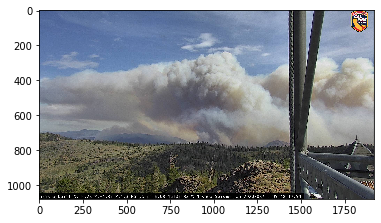

In [2]:
img_path = r'C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\data\images\mixed set\187.jpg'
img0 = mpimg.imread(img_path)
plt.imshow(img0) 

In [3]:
### sepcify the range of x and y values within which the rectangle lies 
### this is in the form of (y1,x1,y2,x2) 


bbox0 = np.array([[210,10,700,650], [450,700,750,1450]]) 
labels = np.array([1,1]) 

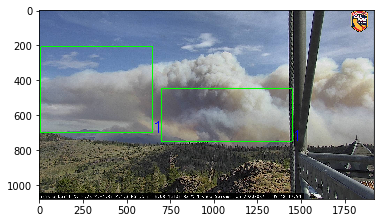

In [4]:
img0_clone = np.copy(img0) 
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]),(bbox0[i][3], bbox0[i][2]), color=(0,255,0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])) , (bbox0[i][3] , bbox0[i][2]) , cv2.FONT_HERSHEY_SIMPLEX, 3 , (0,0,255), thickness=3)
plt.imshow(img0_clone)
plt.show() 

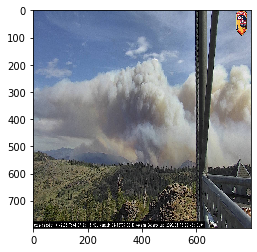

In [5]:
img = cv2.resize(img0, dsize=(800,800), interpolation=cv2.INTER_CUBIC) 
plt.imshow(img)
plt.show() 

In [6]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0] 
ratioList = [Hratio, Wratio, Hratio, Wratio]
bbox = []

for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioList)]
    bbox.append(box)

bbox = np.array(bbox) 
print(bbox) 

[[155   4 518 270]
 [333 291 555 604]]


### The input to faster RCNN model should always be 800x800x3 

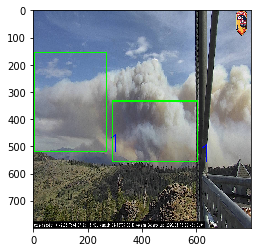

In [7]:
img_clone = np.copy(img) 
bbox_clone = bbox.astype(int) 
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]),(bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3) 
    cv2.putText(img_clone, str(int(labels[i])) , (bbox[i][3] , bbox[i][2]) , cv2.FONT_HERSHEY_SIMPLEX, 3 , (0,0,255), thickness=3)
plt.imshow(img_clone)
plt.show() 

In [8]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda GeForce GTX 1050 Ti


### VGG16 to extract features from input images

### Input images= ( batch_size, H=800, W=800, d=3) 
### Features : (batch_size, H=50 , W=50, d=512) 

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(device) 
fe = list(model.features) 
print(len(fe))

31


In [10]:
params = list(model.parameters())
#print(params) 
#weight = params[-1].data.cpu().numpy().squeeze() 
#print(weight.shape) 
weight = np.squeeze(params[29].data.cpu().numpy())
print(weight.shape) 

#for param in model.parameters():
    #print(param.shape)

(4096,)


### Once the features pass through vgg16, the size at the output is 50 x 50 x 512
### This is the output after layer 30 of vgg16

In [11]:
dummy_img = torch.zeros((1,3,800,800)).float() 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)

for i in fe:
    k = i(k)
    
    if k.size()[2] < 800//16:
        break
    req_features.append(i) 
    out_channels = k.size()[1]

print(len(req_features)) 
print(out_channels) 



torch.Size([1, 3, 800, 800])
30
512


### Convert this list into a Sequential Module

In [12]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [13]:
transform = transforms.Compose([transforms.ToTensor()]) 
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size()) 

torch.Size([1, 512, 50, 50])


### Visualize the first 5 channels of the 50x50x512 feature maps obtained from vgg16

(512, 50, 50)


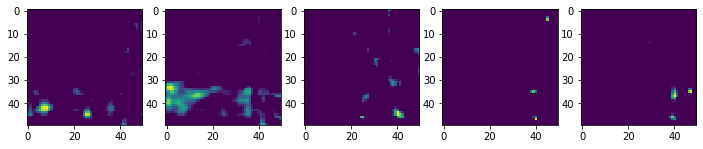

In [14]:
imgArray = out_map.data.cpu().numpy().squeeze(0)
print(imgArray.shape) 

fig = plt.figure(figsize = (12,4)) 
figNo = 1

for i in range(5):
    fig.add_subplot(1,5,figNo)
    plt.imshow(imgArray[i]) 
    figNo +=1
    
plt.show() 


### Generate 22,500 anchor boxes on each input image

#### 50x50 = 2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9 = 22,500

### Before the feature maps are passed to the final classifier to predict the bounding box and the label, it has to be given to the RPN to train it for bounding box generation

In [15]:
# x, y intervals to generate anchor box center
#We generate the centers for the anchors which consist of 2500 anchors

fe_size = (800//16)

ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)

print(len(ctr_x), ctr_x) 
print(len(ctr_y), ctr_y) 

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [16]:
# coordinates of the 2500 center points to generate anchor boxes 

index = 0
ctr = np.zeros((2500, 2))

for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        
        index +=1
        
print(ctr.shape)

(2500, 2)


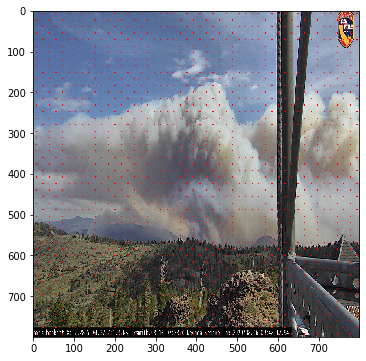

In [17]:
## display the 2500 anchors

img_clone = np.copy(img)

plt.figure(figsize=(9,6)) 

for i in range(ctr.shape[0]):
    
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])) , radius=1, color=(255,0,0) ,thickness = 1) 

plt.imshow(img_clone)
plt.show() 
               
               

### for each of the 2500 anchors, generate 9 anchor boxes 
### 2500*9 = 22500


In [18]:
### we have generated anchor boxes at pre-defined scales and aspect ratios

ratios = [0.5, 1, 2]
scales = [8,16,32]

sub_sample = 16

anchor_boxes = np.zeros(((fe_size * fe_size *9) , 4)) 

index = 0

for c in ctr:
    ctr_y, ctr_x = c
    
    for i in range(len(ratios)):
        for j in range(len(scales)):
            
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ratios[i])
            
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape) 

(22500, 4)


### display the 9 anchor boxes of one anchor and the ground truth bbox 

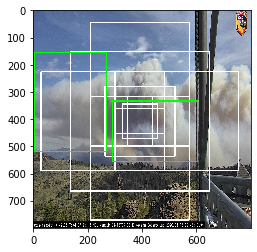

In [19]:
img_clone = np.copy(img) 

for i in range(11025 , 11034):     #9*1225 = 11025  -- 9 anchor boxessss
    
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2]) 
    cv2.rectangle(img_clone, (x0,y0) , (x1,y1) , color=(255,255,2550) , thickness=3)
    
### ground truth box
    
for i in range(len(bbox)):
     cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]),(bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3)

plt.imshow(img_clone) 

plt.show() 

### valid anchor boxes ---- grount truth bboxes --- IOU

### Ignore cross boundary anchor boxes --- i.e ignore the anchor boxes that have crossed the boundary of the image, we will not use them to train our RPN

### valid anchor boxes with (y1,x1) > 0 and (y2,x2) <= 800

In [20]:
## we ignore those anchor boxes that have crossed 800 by 800

index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) & 
    (anchor_boxes[:, 1] >= 0) & 
    (anchor_boxes[:, 2] <= 800) & 
    (anchor_boxes[:, 3] <= 800) 
   )[0]

print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)



(8940,)
(8940, 4)


### 8940 anchor boxes are valid out of 22500 present in the image

In [21]:
### Calculate IOU of the valid anchor boxes

### Since we have 8940 valid anchor boxes and 2 ground truth objects, we should get an array with (8940, 2) as the output


ious = np.empty((len(valid_anchor_boxes), 2) , dtype = np.float32) 
ious.fill(0) 

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    
    anchor_area = (ya2 - ya1) * (xa2 - xa1) 
    
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2]) 
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou= 0.
        
        ious[num1, num2] = iou

print(ious.shape) 
        

(8940, 2)


### what anchor box has max iou with the ground truth bbox

In [22]:
## since we have 2 ground truth boxes, we will have 2 such valid anchor boxes that have maximum intersection with the Ground truth box respectively

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious) 

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]

print(gt_argmax_ious) 
print(gt_argmax_ious.shape) 



[ 38 305]
[5.332249 5.221095]
[  38   39   40   42   44   46   48   50   52   54  305  309  313  317
  321  325  329  457  461  465  469  473  477  481  634  639  644  649
  654  659  664  820  825  830  835  840  845  850 1006 1011 1016 1021
 1026 1031 1036 1223 1229 1235 1241 1247 1253 1259 1451 1457 1463 1469
 1475 1481 1487 1679 1685 1691 1697 1703 1709 1715 1907 1913 1919 1925
 1931 1937 1943 2135 2141 2147 2153 2159 2165 2171 2380 2387 2393 2399
 2405 2411 2417 2626 2633 2639 2645 2651 2657 2663 2872 2879 2885 2891
 2897 2903 2909 3118 3125 3131 3137 3143 3149 3155 3364 3371 3377 3383
 3389 3395 3401 3610 3617 3623 3629 3635 3641 3647 3856 3863 3869 3875
 3881 3887 3893 4124 4132 4139 4146 4153 4160 4167]
(136,)


### What ground truth bbox is associated with each anchor box

In [23]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)

print(argmax_ious) 

max_ious = ious[np.arange(len(index_inside)) , argmax_ious]

print(max_ious) 
print(max_ious.shape)

(8940,)
[0 0 0 ... 1 1 1]
[4.997187   4.997187   4.997187   ... 0.23578851 0.23578851 0.23578851]
(8940,)


In [24]:
label = np.empty((len(index_inside),) , dtype=np.int32) 
label.fill(-1)

print(label.shape) 

(8940,)


#### use iou to assign 1 (objects) to two kind of anchors
#### a) The anchors with the heighest iou overlap with a ground-truth box
#### b) An anchor that has an IOU overlap higher than 0.7 with the ground-truth box

#### Assign 0 (background) to an anchor if its IOU ratio is lower than 0.3 for ground-truth boxes


In [25]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < pos_iou_threshold] = 0

In [26]:
### out of 8940, we keep only 256 anchor boxes
### we keep the remaining as -1

### if positive samples are more than negative samples, disable remaining
### if negative samples are more than positive samples, disable remaining


n_sample = 256
pos_ratio = 0.5

n_pos = pos_ratio * n_sample
pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - int(n_pos)) , replace=False) 
    label[disable_index] = -1

    
n_neg = n_sample * np.sum(label == 1) 
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - int(n_neg)) , replace=False) 
    label[disable_index] = -1
    


In [27]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

(8940, 4)


In [28]:
#valid anchor boxes 

height = valid_anchor_boxes[:,2] - valid_anchor_boxes[:,0]
width = valid_anchor_boxes[:,3] - valid_anchor_boxes[:,1]

ctr_y = valid_anchor_boxes[:,0] + 0.5 * height
ctr_x = valid_anchor_boxes[:,1] + 0.5 * width


base_height = max_iou_bbox[:,2] - max_iou_bbox[:,0]
base_width = max_iou_bbox[:,3] - max_iou_bbox[:,1]

base_ctr_y = max_iou_bbox[:,0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:,1] + 0.5 * base_width

eps = np.finfo(height.dtype).eps

height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width

dh =np.log(base_height / height)
dw =np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()

print(anchor_locs.shape)

(8940, 4)


In [29]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)

anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:] , dtype= anchor_locs.dtype)
anchor_locations.fill(0)

anchor_locations[index_inside , :] = anchor_locs
print(anchor_locations.shape) 


(22500,)
(22500, 4)


### 22500 ROIs (Region proposals)

In [30]:
### we send the feature maps to the RPN to generate the 22500 region proposals
### ground truth boxes --- 2x5 --- 2 boxes with 5 parameters....x,y,w,h,label

in_channels = 512
mid_channels = 512

n_anchor = 1

conv1 = nn.Conv2d(in_channels, mid_channels, 3,1,1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4,1,1,0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2,1,1,0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0.], device='cuda:0')

In [31]:
x = conv1(out_map.to(device)) 
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 4, 50, 50]) torch.Size([1, 2, 50, 50])


(4, 50, 50)


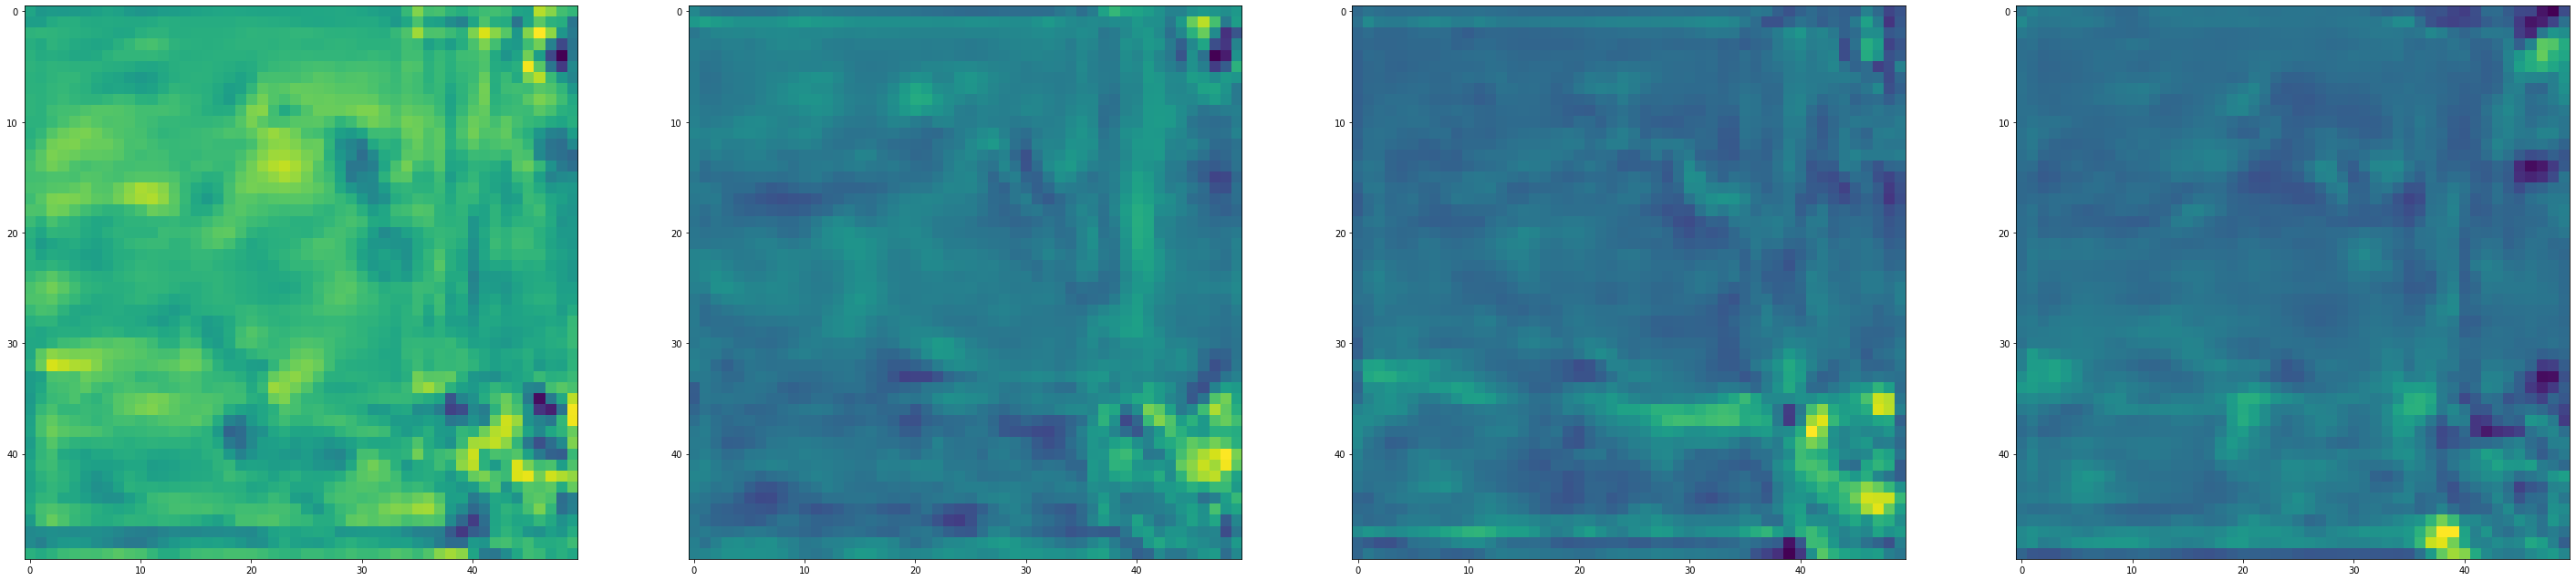

In [32]:
anchorArray = pred_anchor_locs.data.cpu().numpy().squeeze(0)
print(anchorArray.shape) 

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,4, figsize=(50,50))

for i,ax in enumerate(axes.flat):
    ax.imshow(anchorArray[i]) 

(4, 50, 50)
(50, 50)
(2500, 1)
(4096,)
(1, 4096)
(2500, 4096)
(1, 256, 256)


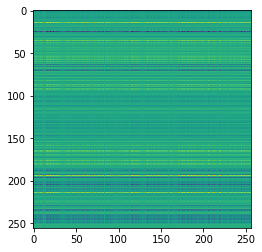

In [33]:
# generate the class -activation maps upsample to 256x256

size_upsample = (256, 256)
#bz, nc, h, w = feature_conv.shape
print(anchorArray.shape) 
array1 = anchorArray[0] 
print(array1.shape) 
w,h = array1.shape
beforeDot = array1.reshape((w*h , 1)) 
print(beforeDot.shape)

print(weight.shape) 
new_weight = np.array([weight]) 
print(new_weight.shape) 

cam = np.matmul(beforeDot, new_weight)
print(cam.shape)

output_cam = [] 

cam = cam - np.min(cam)
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
output_cam.append(cv2.resize(cam_img, size_upsample)) 
output_cam = np.array(output_cam) 
print(output_cam.shape)
output_cam = output_cam.squeeze(0)

plt.imshow(output_cam)
#plt.imshow(cam) 


(1080, 1920, 3)
(1080, 1920)
(50, 50)
(1080, 1920)
(1080, 1920)


(-0.5, 1919.5, 1079.5, -0.5)

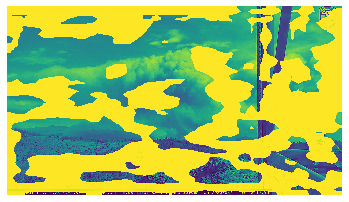

In [39]:
import cv2
img = cv2.imread(img_path) 
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape) 

array1 = anchorArray[0] 
print(array1.shape) 
anchorArray_resized = cv2.resize(array1, (img.shape[1], img.shape[0]))
print(anchorArray_resized.shape) 
cam_img = np.uint8(255 * anchorArray_resized) 
print(cam_img.shape)


hif = 1.0
superimposed_img = cam_img * hif + gray

output =  r'C:\Users\Sanika\Desktop\LAB Work\Alert-Wildfire\184_cam.jpg'

cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)
plt.imshow(img)
plt.axis('off')


In [35]:
pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(1,-1,4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1,50,50,9,2)[:,:,:,:,1].contiguous().view(1,-1)
print(objectness_score.shape)

pred_cls_scores =pred_cls_scores.view(1,-1,2)
print(pred_cls_scores.shape) 

torch.Size([1, 2500, 4])
torch.Size([1, 50, 50, 2])


RuntimeError: shape '[1, 50, 50, 9, 2]' is invalid for input of size 5000

### RPN --- 22500 ROIs --- 22500 Anchor boxes --- RPN loss

In [ ]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape , rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

In [ ]:
### RPN loss --- RPN cross entropy loss -- this is the loss obtained from the rpn_score and the gt_rpn_score
### rpn score --- obtained from the predicted class score that is predicted for each anchor
### this is obtained by applying a classfication layer to the feature maps (512 channels) --- 9 anchors x 2 labels per anchor

rpn_cls_loss = F.cross_entropy(rpn_score ,gt_rpn_score.long().to(device), ignore_index = -1) 
print(rpn_cls_loss) 

In [ ]:
# for regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

#take those bounding boxes which have positive labels

mask_loc_preds = rpn_loc[mask].view(-1,4)      ### obtained by passing the features through the conv layers
mask_loc_targets = gt_rpn_loc[mask].view(-1,4)       ### obtained by generating the anchors at various scales and aspect ratios
print(mask_loc_preds.shape, mask_loc_targets.shape) 

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
#print(x) 
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >=1).float() * (x-0.5))
print(rpn_loc_loss.sum()) 



In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10    ###The parameter lambda controls the balance between the 2 task losses
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss =  rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

In [ ]:
nms_thresh = 0.7
n_train_pre_nms = 12000   #no of train pre-NMS
n_train_post_nms = 2000   # after nms, training Fast RCNN using 2000 RPN proposals

n_test_pre_nms = 6000
n_test_post_nms = 300   #durng testing we evaluate 300 proposals

min_size = 16

In [ ]:
#The labelled 22500 anchor boxes
# format converted from y1,x1,y2,x2 to ctrx ctry h w

#The anchor boxes predicted by the RPN is called the ROI
# The anchor boxes generated on the input image are the original anchor boxes
# we use the anchor boxes and ROI to calculate the RPN loss
# to train the RPN
# the ROIs are finally passed to the detection network to detect the box and label of the object
# most of the anchor boxes ar overlapped so we used non-maximum supression to select only 2000 ROIs
#3 nms helps us to filter out only 2000 rois from 22500 rois

anc_height = anchor_boxes[:,2] - anchor_boxes[:,0]
anc_width =  anchor_boxes[:,3] - anchor_boxes[:,1]
anc_ctr_y = anchor_boxes[:,0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:,1] + 0.5 * anc_width
print(anc_ctr_x.shape)
print(anc_ctr_y.shape) 

## The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy,dx,dh,dw)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]

print(dy.shape)


ctr_y = dy* anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx* anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis] 

h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis] 

print(w.shape)

In [ ]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)

roi[:, 0::4] = ctr_y - 0.5*h
roi[:, 1::4] = ctr_x - 0.5*w

roi[:, 2::4] = ctr_y + 0.5*h
roi[:, 3::4] = ctr_x + 0.5*w

print(roi.shape) 

In [ ]:
### clip the predicted boxes to the image

img_size = (800,800)
roi[:, slice(0,4,2)] = np.clip(roi[:, slice(0,4,2)], 0, img_size[0])
roi[:, slice(1,4,2)] = np.clip(roi[:, slice(0,4,2)], 0, img_size[1])

print(roi.shape, np.max(roi) , np.min(roi))

In [ ]:
### Remove the predicted boxes with the height or width < threshold

hs = roi[:, 2] - roi[:,0]
ws = roi[:, 3] - roi[:,1]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]

print(keep.shape, roi.shape, score.shape) 

In [ ]:
### sort all proposal score pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

order = order[:n_train_pre_nms] 
roi = roi[order, :]
print(order.shape, roi.shape)

In [ ]:
##Take all the roi boxes (roi array)

y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

## Find the areas of all the boxes
areas = (x2 - x1 + 1) * (y2 - y1 + 1)
print(areas.shape)


In [ ]:
## Take the indices of order the probablity score in descending order

order = order.argsort()[::-1]
keep = []

while(order.size > 0):
    i = order[0]     ##take the first element and append to keep
    keep.append(i)
    
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]]) 
    
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w*h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
    
keep = keep[:n_train_post_nms]
roi = roi[keep]
print(len(keep) , roi.shape) 

In [ ]:
n_sample = 128    #we sample only 128 roi samples at the end
pos_ratio = 0.25   #number of positive examples out of n_samples
pos_iou_thresh = 0.5

neg_iou_thresh_hi = 0.5   #iou 0-0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2 , j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2-yb1)*(xb2-xb1)
        
        inter_x1 = max([xb1, xa1]) 
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2])
        
        if(inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou =0
        ious[num1, num2] = iou
print(ious.shape)
        

In [ ]:
#find out which ground truth has max IOU for each region proposal

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)


# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label) 

In [ ]:
## select the foreground ROIs as per the pos_iou_thresh and 128 x 0.25 foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]

pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
    pos_index = np.random.choice(
    pos_index, size=pos_roi_per_this_image, replace=False)
    
print(pos_roi_per_this_image)
print(pos_index)


neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]

neg_roi_per_this_image = n_sample - pos_roi_per_this_image

neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))


if neg_index.size > 0:
    neg_index = np.random.choice(
    neg_index, size=neg_roi_per_this_image, replace=False)
    
print(neg_roi_per_this_image)
print(neg_index)



In [ ]:
## display roi samples with positive 

img_clone = np.copy(img) 

for i in range(pos_roi_per_this_image):  
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0,y0) , (x1,y1) , color=(255,255,2550) , thickness=3)
    
for i in range(len(bbox)):
     cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]),(bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3)

plt.imshow(img_clone) 

plt.show() 

In [ ]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]

gt_roi_labels[pos_roi_per_this_image:] = 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

In [ ]:
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

In [ ]:
height = sample_roi[:,2]- sample_roi[:,0]
width =  sample_roi[:,3]- sample_roi[:,1]
ctr_y =  sample_roi[:,0] + 0.5* height
ctr_x =  sample_roi[:,1] + 0.5* width


base_height = bbox_for_sampled_roi[:,2]- bbox_for_sampled_roi[:,0]
base_width =  bbox_for_sampled_roi[:,3]- bbox_for_sampled_roi[:,1]
base_ctr_y =  bbox_for_sampled_roi[:,0] + 0.5* base_height
base_ctr_x =  bbox_for_sampled_roi[:,1] + 0.5* base_width


In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width,eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

In [ ]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0* np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0,2,1,4,3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

In [ ]:
size = (7,7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)
rois = rois.long()

num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[.... roi[2]:(roi[4] + 1), roi[1]:(roi[3] + 1)]
    tmp = adaptive_max_pool(im) 
    output.append(tmp[0])

output = torch.cat(output, 0)
print(output.shape)
    